# Sparse State Cost Benchmark

In `QSP_Method_Call_Demo.ipynb` and `[Detailed Implementation] QSP.ipynb`, we mostly consider dense states (i.e., all coeffcients $x_i$'s have non-zero values). In this notebook, we will benchmark the required multi-control rotation gates for sparse states (i.e., only $d << 2^n$ coefficients are zero).

In [1]:
import numpy as np
import random
import math
import itertools

from helper_functions import *
from qsp_circ_construction_qubit_efficient import compute_ry_rotation_angle

We can define a method to count the number of required rotations. If the rotation angle is computed to be $0$, we don't need to invoke the multi-control gate instruction, which would save a lot of the gate costs.

In [2]:
def count_none_zero_rotations(normalized_sparse_real_array: np.ndarray, tolerance = 1e-10) -> int:
    """
    Function to count the number of none-zero rotation angles
    
    @param normalized_sparse_real_array: the entire wave function array vector values to be encoded
    @tolerance: a float number to decide if the computed angle is close enough to be treated as 0
    
    @return: a int that holds the non-zero angle count
    """
    n = int(math.log2(len(normalized_sparse_real_array)))
    count = 0
    for s in range(n, 0, -1): # as it exactly defined in the figure above
            for j in range(2 ** (n - s), 0, -1):
                if compute_ry_rotation_angle(s, j, normalized_sparse_real_array) > tolerance:
                    count += 1
    return count

We can use a brute force method to iterate through all the combinations of the appearance of non-zero value indices:

In [3]:
def get_combinations(n: int, d: int):
    if d > n:
        print("Invalid input. 'd' must be less than or equal to 'n'.")
        return []

    elements = list(range(n + 1))
    combinations = list(itertools.combinations(elements, d))
    return [list(combo) for combo in combinations]

For example, we can set some small values are see all the possible combinations:

In [4]:
n = 2
d = 2

combinations = get_combinations(2 ** n - 1, d)
for combo in combinations:
    print(combo)

[0, 1]
[0, 2]
[0, 3]
[1, 2]
[1, 3]
[2, 3]


These arrays will then represent the non-zero coefficient positions in the input arrays.

Now back to some larger numbers, we can get the average none-zero angle counts and the max angle counts for this particular set of $(n, d)$

In [5]:
n = 5
d = 3
combinations = get_combinations(2 ** n - 1, d)
count_array = []
for combo in combinations:
    w_like_state = generate_normalized_real_sparse_array(n, combo)
    count_array.append(count_none_zero_rotations(w_like_state))
# print(count_array)
print('The mean count is ' + str(np.mean(count_array)))
print('The max count is ' + str(np.max(count_array)))
print('We have ' + str(len(count_array)) + ' combinations')

The mean count is 6.380645161290323
The max count is 12
We have 4960 combinations


Plot it, looks like a normal distrbution.

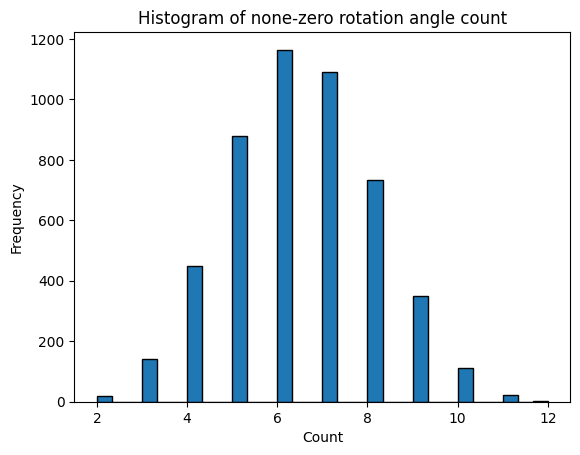

In [6]:
import matplotlib.pyplot as plt

plt.hist(count_array, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Histogram of none-zero rotation angle count")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

We can also try to sample some combinations if $(n, d)$ gets larger (and thus iterating through all possible combinations is not scalable):

In [7]:
n = 7
d = 3
max_iter = 10
count_array = []
for _ in range(max_iter):
    result = sorted(random.sample(range(2 ** n), d))
    print(result)

[5, 60, 88]
[78, 108, 122]
[5, 52, 97]
[33, 58, 92]
[22, 58, 111]
[35, 78, 96]
[34, 94, 109]
[9, 43, 107]
[49, 87, 90]
[60, 119, 127]


Now sample 1000 combinations for $n = 9$ and $d = 3$ and get the none-zero rotation angles for each of the samples index array:

In [8]:
n = 9
d = 3
max_iter = 1000
count_array = []
for _ in range(max_iter):
    result = sorted(random.sample(range(2 ** n), d))
    w_like_state = generate_normalized_real_sparse_array(n, result)
    count_array.append(count_none_zero_rotations(w_like_state))
print(np.mean(count_array))
print(np.max(count_array))

12.181
19


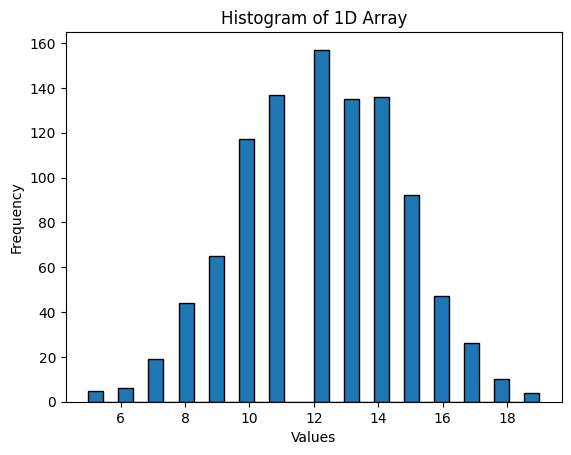

In [9]:
plt.hist(count_array, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Histogram of 1D Array")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

So, how does the none zero angle count behave as n and d scales up?

Let's first do a case for different $n$ values while fixing $d = 6$:

In [10]:
n_array = []
mean_array = []
max_array = []
for n in range(4, 13):
    d = 6
    max_iter = 1000
    count_array = []
    for _ in range(max_iter):
        result = sorted(random.sample(range(2 ** n), d))
        w_like_state = generate_normalized_real_sparse_array(n, result)
        count_array.append(count_none_zero_rotations(w_like_state))
    n_array.append(n)
    mean_array.append(np.mean(count_array))
    max_array.append(np.max(count_array))
# print(n_array)
print(mean_array)
print(max_array)

[8.246, 10.947, 13.407, 16.273, 19.216, 22.186, 25.062, 27.998, 30.888]
[12, 16, 22, 25, 29, 32, 35, 39, 42]


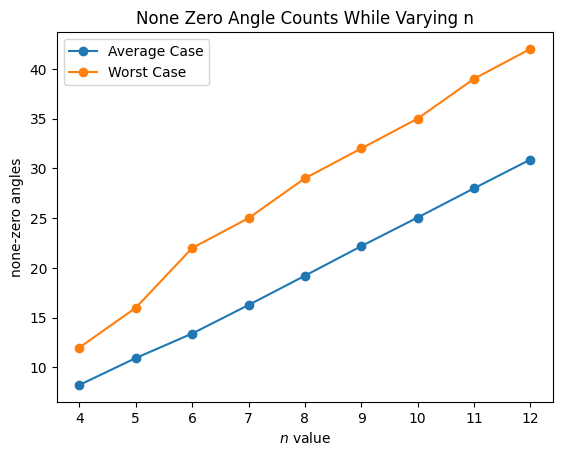

In [11]:
fig, ax = plt.subplots()
ax.plot(n_array, mean_array, label='Average Case', marker='o')  # Plot some data on the axes.
ax.plot(n_array, max_array, label='Worst Case', marker='o')  # Plot some data on the axes.
ax.set_xlabel('$n$ value')  # Add an x-label to the axes.
ax.set_ylabel('none-zero angles')  # Add a y-label to the axes.
ax.set_title("None Zero Angle Counts While Varying n")  # Add a title to the axes.
ax.legend()  # Add a legend.

Now do another case for different d values while fixing $n = 8$

In [12]:
d_array = []
mean_array = []
max_array = []
for d in range(4, 13):
    n = 8
    max_iter = 1000
    count_array = []
    for _ in range(max_iter):
        result = sorted(random.sample(range(2 ** n), d))
        w_like_state = generate_normalized_real_sparse_array(n, result)
        count_array.append(count_none_zero_rotations(w_like_state))
    d_array.append(d)
    mean_array.append(np.mean(count_array))
    max_array.append(np.max(count_array))
# print(n_array)
print(mean_array)
print(max_array)

[13.735, 16.493, 19.053, 21.684, 24.25, 26.417, 28.751, 30.992, 33.23]
[24, 26, 28, 32, 37, 39, 41, 48, 46]


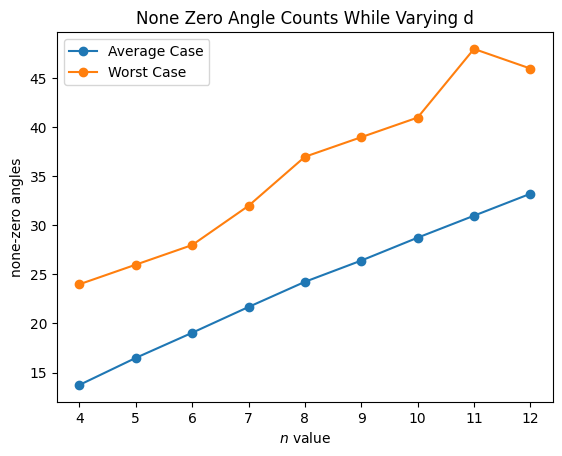

In [13]:
fig, ax = plt.subplots()
ax.plot(n_array, mean_array, label='Average Case', marker='o')  # Plot some data on the axes.
ax.plot(n_array, max_array, label='Worst Case', marker='o')  # Plot some data on the axes.
ax.set_xlabel('$n$ value')  # Add an x-label to the axes.
ax.set_ylabel('none-zero angles')  # Add a y-label to the axes.
ax.set_title("None Zero Angle Counts While Varying d")  # Add a title to the axes.
ax.legend()  # Add a legend.

We can see that the overall gate count complexity is roughly linear to both $n$ and $d$, thus bring us to $O(nd)$ total gate complexity. Since we have qubit complexity of $O(n)$, this will bring us a $O(n^2d)$ spacetime allocation. 

[For Alex's reference only] The Zhang et al. paper has achieved $\Theta(\log(nd))$ with $O(nd\log(d))$ ancilla qubits for arbitrary d-sparse states, which would result in $O(nd\log(nd)\log(d))$ spacetime allocation. For near term simulation (e.g., number of qubit is limited), this difference probably won't matter that much, not to mention that the dense case is not theoretically optimal anyway. Maybe one day someone can try attempt the Sun et al. method and see how the performance compares when the constants are factored in.